### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
# new source https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [4]:
req = requests.get(download_link)
rki_raw = pd.read_csv(StringIO(req.text))

In [5]:
rki_raw.tail()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
132252,5674051,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020/04/22 00:00:00,16077,"09.05.2020, 00:00 Uhr",0,-9,2020/04/17 00:00:00,0,1,1,Nicht übermittelt
132253,5674052,16,Thüringen,LK Altenburger Land,A80+,M,1,1,2020/03/24 00:00:00,16077,"09.05.2020, 00:00 Uhr",0,0,2020/03/16 00:00:00,-9,0,1,Nicht übermittelt
132254,5674053,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/03/27 00:00:00,16077,"09.05.2020, 00:00 Uhr",0,-9,2020/03/23 00:00:00,0,1,1,Nicht übermittelt
132255,5674054,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/05/07 00:00:00,16077,"09.05.2020, 00:00 Uhr",0,-9,2020/05/05 00:00:00,-9,0,1,Nicht übermittelt
132256,5674055,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/05/06 00:00:00,16077,"09.05.2020, 00:00 Uhr",0,-9,2020/05/04 00:00:00,-9,0,1,Nicht übermittelt


In [6]:
def new_cases_by_date(rki_raw, rki_flag_column='Neuer Fall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Refdatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [7]:
rki_cases = new_cases_by_date(rki_raw, rki_flag_column='NeuerFall', rki_count_columns='AnzahlFall')
rki_death = new_cases_by_date(rki_raw, rki_flag_column='NeuerTodesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='NeuGenesen', rki_count_columns='AnzahlGenesen')

In [8]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeath', 'AnzahlGenesen': 'NewRecovered'}
rki.rename(columns_dict, axis=1, inplace=True)
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeath,NewRecovered
Refdatum,,,
2020-05-04,593,10.0,0.0
2020-05-05,696,8.0,0.0
2020-05-06,709,2.0,0.0
2020-05-07,630,0.0,0.0
2020-05-08,387,1.0,0.0


In [9]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Refdatum,,,,,,,,
2020-04-29,1066,16.0,4.0,162705,7310.0,143256.0,19449.0,0.054810
2020-04-30,1069,16.0,5.0,163774,7326.0,143261.0,20513.0,0.052113
2020-05-01,724,13.0,1.0,164498,7339.0,143262.0,21236.0,0.034093
2020-05-02,574,2.0,3.0,165072,7341.0,143265.0,21807.0,0.026322
2020-05-03,464,7.0,0.0,165536,7348.0,143265.0,22271.0,0.020834
2020-05-04,593,10.0,0.0,166129,7358.0,143265.0,22864.0,0.025936
2020-05-05,696,8.0,0.0,166825,7366.0,143265.0,23560.0,0.029542
2020-05-06,709,2.0,0.0,167534,7368.0,143265.0,24269.0,0.029214
2020-05-07,630,0.0,0.0,168164,7368.0,143265.0,24899.0,0.025302


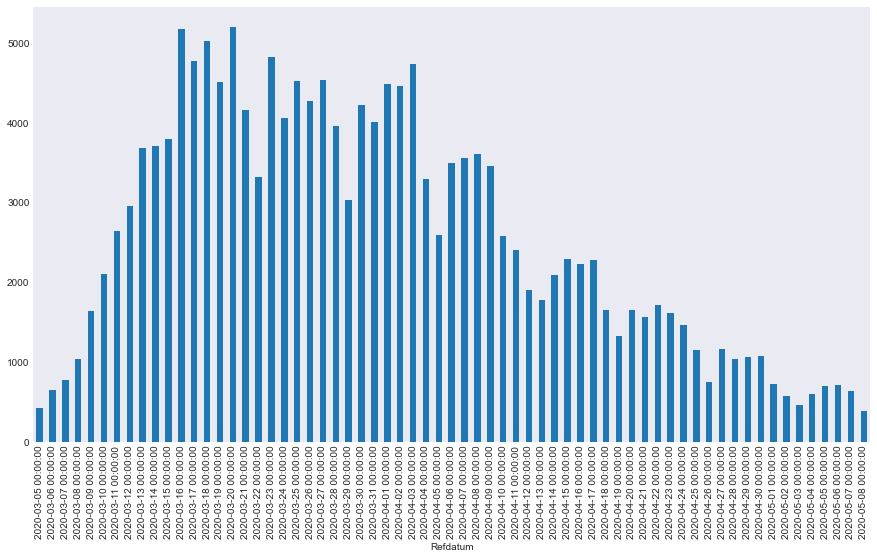

In [10]:
rki.NewCases['03-05-2020':].plot.bar()

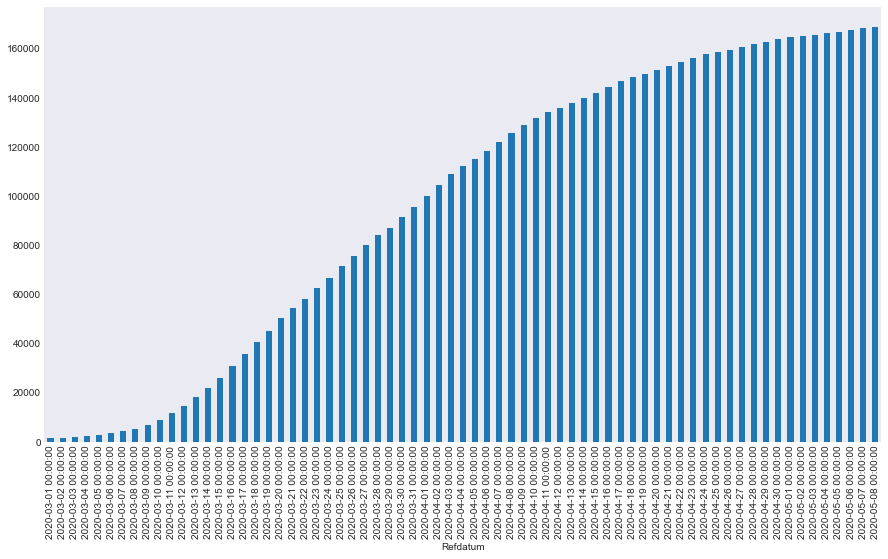

In [11]:
rki.Cases['03-01-2020':].plot.bar()

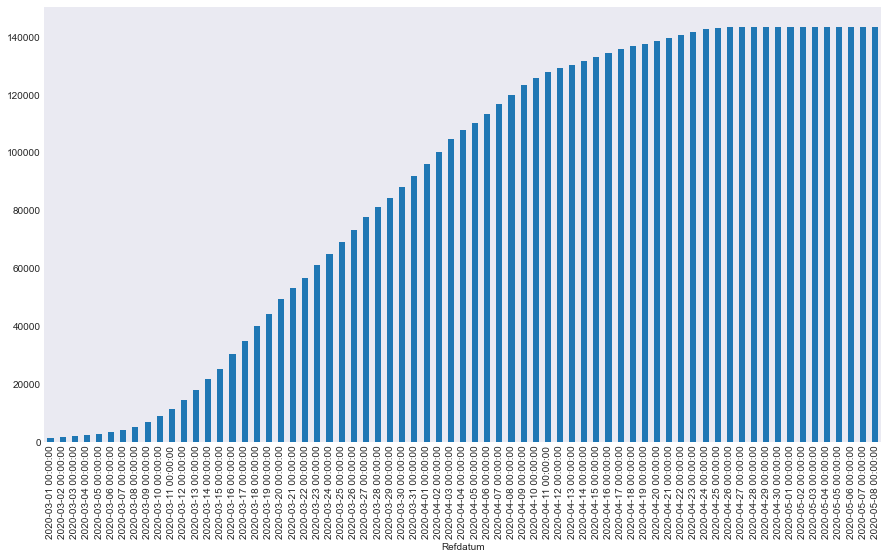

In [12]:
rki.Recovered['03-01-2020':].plot.bar()

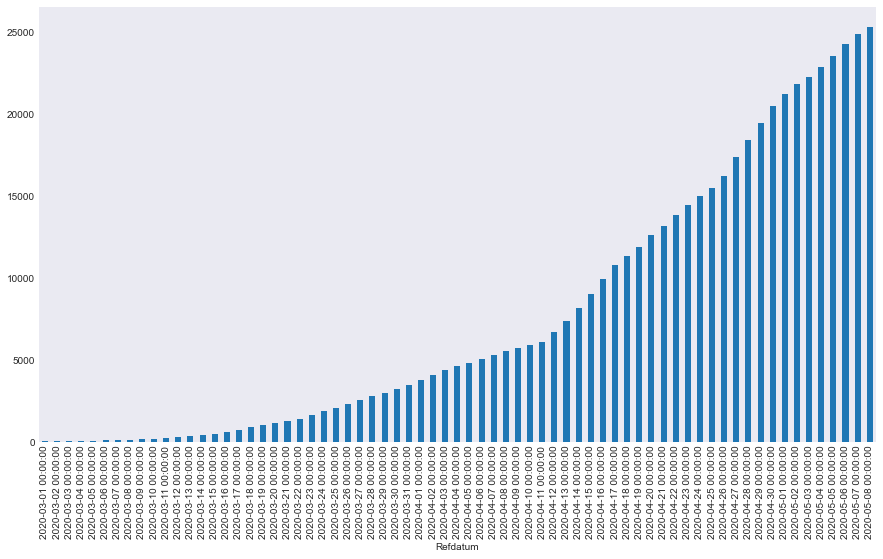

In [13]:
rki.ActiveCases['03-01-2020':].plot.bar()

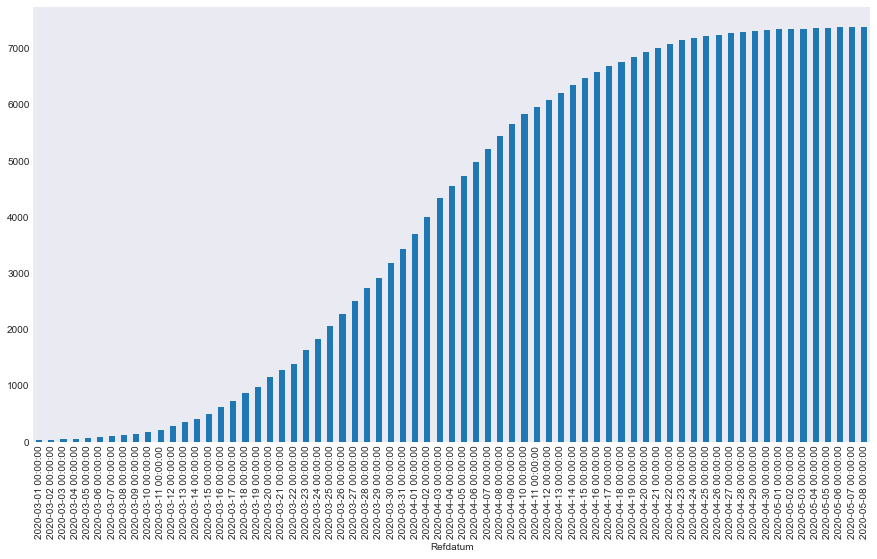

In [14]:
rki.Death['03-01-2020':].plot.bar()

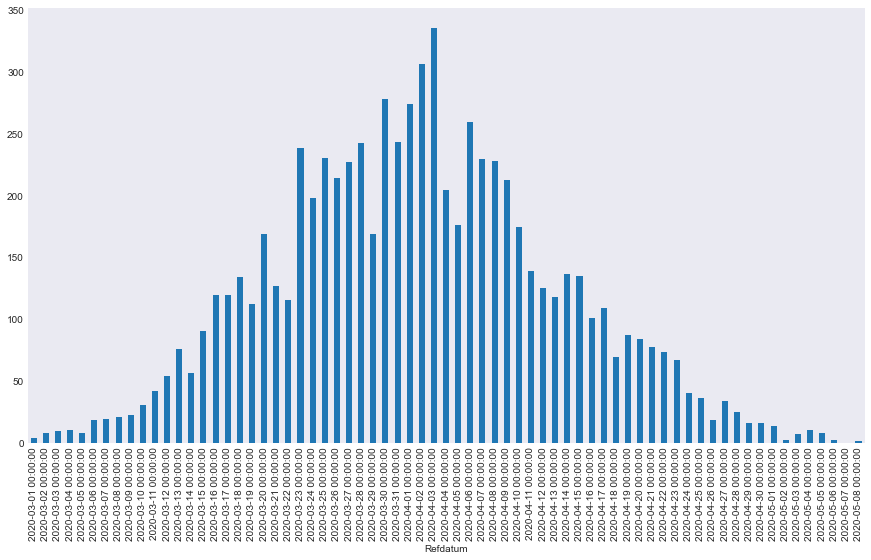

In [15]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

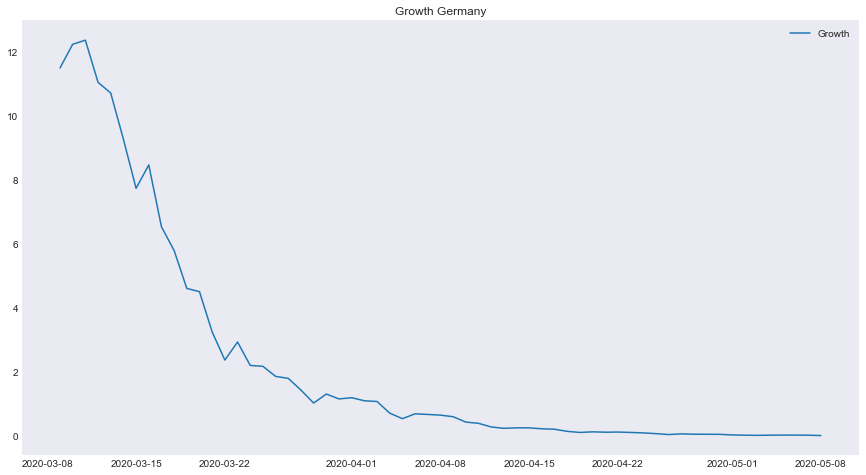

In [34]:
start_date = '03-09-2020'
x = rki[start_date:].index
plt.plot(x, rki.Growth[start_date:], label='Growth')
#plt.plot(x, rki.Growth.ewm(span=6,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

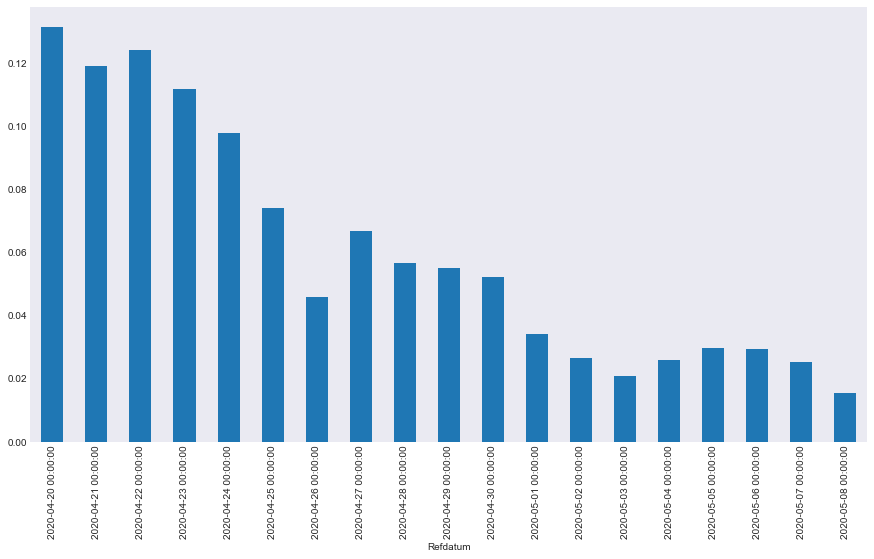

In [21]:
rki.Growth['04-20-2020':].plot.bar()

Text(0.5, 1.0, 'New Cases Germany')

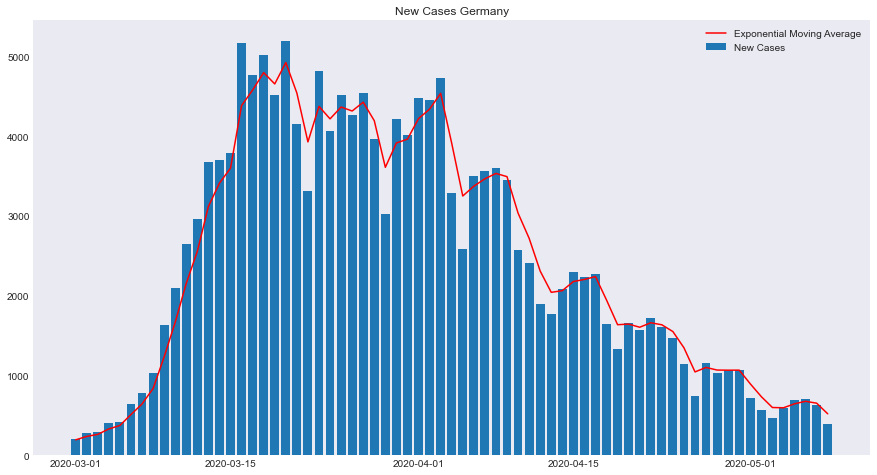

In [18]:
start_date = '03-01-2020'
x = rki[start_date:].index

plt.bar(x, rki.NewCases[start_date:], label='New Cases')
plt.plot(x, rki.NewCases.ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('New Cases Germany')

In [19]:
rki.tail(20)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Refdatum,,,,,,,,
2020-04-19,1329,87.0,780.0,149536,6840.0,137629.0,11907.0,0.111615
2020-04-20,1654,84.0,948.0,151190,6924.0,138577.0,12613.0,0.131135
2020-04-21,1567,77.0,999.0,152757,7001.0,139576.0,13181.0,0.118883
2020-04-22,1719,73.0,1051.0,154476,7074.0,140627.0,13849.0,0.124124
2020-04-23,1612,67.0,1000.0,156088,7141.0,141627.0,14461.0,0.111472
2020-04-24,1467,40.0,922.0,157555,7181.0,142549.0,15006.0,0.097761
2020-04-25,1145,36.0,671.0,158700,7217.0,143220.0,15480.0,0.073966
2020-04-26,744,18.0,7.0,159444,7235.0,143227.0,16217.0,0.045878
2020-04-27,1158,34.0,16.0,160602,7269.0,143243.0,17359.0,0.066709
